In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
#read data
training_path ='SEM-2012-SharedTask-CD-SCO-training-simple.v2.features.conll'
dev_path = 'SEM-2012-SharedTask-CD-SCO-dev-simple.v2.features.conll'

training = pd.read_csv(training_path, encoding ='utf-8', sep='\t')
dev = pd.read_csv(dev_path, encoding ='utf-8', sep='\t')

In [4]:
#explore data
training.head(5)

,Book,Sent nr,Token nr,Token,Label,Pre token,Next token,Lemma,Pre lemma,Next lemma,POS,Pre POS,Next POS,POS_classified,Punctuation_spacy,Punctuation_python,MatchesNegExp,HasNegAffix,Negated event,NegAffix
0,baskervilles01,0,0,Chapter,O,<BOD>,1.,chapter,<BOD>,1,NN,<BOD>,CD,NN,['0'],0,0,0,-,-
1,baskervilles01,0,1,1.,O,Chapter,Mr.,1,chapter,Mr.,CD,NN,NNP,OTH,"['0', '1']",0,0,0,-,-
2,baskervilles01,0,2,Mr.,O,1.,Sherlock,Mr.,1,Sherlock,NNP,CD,NNP,NN,['0'],0,0,0,-,-
3,baskervilles01,0,3,Sherlock,O,Mr.,Holmes,Sherlock,Mr.,Holmes,NNP,NNP,NNP,NN,['0'],0,0,0,-,-
4,baskervilles01,0,4,Holmes,O,Sherlock,Mr.,Holmes,Sherlock,Mr.,NNP,NNP,NNP,NN,['0'],0,0,0,-,-


In [28]:
training_instances = training[['Token','Pre token','Next token','Lemma','Pre lemma','Next lemma','POS','Pre POS','Next POS','POS_classified','Punctuation_python','MatchesNegExp','HasNegAffix','Negated event','NegAffix']].to_dict('records')
dev_instances = dev[['Token','Pre token','Next token','Lemma','Pre lemma','Next lemma','POS','Pre POS','Next POS','POS_classified','Punctuation_python','MatchesNegExp','HasNegAffix','Negated event','NegAffix']].to_dict('records')

# training_instances[:20]

In [29]:
#vectorizing our features
vec = DictVectorizer()
x_train = vec.fit_transform(training_instances)

In [30]:
x_train.shape

(65451, 30273)

In [31]:
x_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
#training SVM model on training data
y_train = training.Label.to_list()
y_dev = dev.Label.to_list()

In [33]:
# without parameters optimization
# classifier = LinearSVC()
# classifier.fit(x_train,y_train)

In [34]:
#try LinearSVC classification algotithm
classifier = LinearSVC()
parameters = dict(
    C = (0.01,0.1,1.0),
    loss = ('hinge','squared_hinge'),
    tol = (1e-4,1e-3,1e-2,1e-1))

grid = GridSearchCV(estimator = classifier, param_grid=parameters, cv=5, scoring='f1_macro')
grid.fit(x_train,y_train)
classifier = grid.best_estimator_

print('Best parameters:',grid.best_params_)

/Users/zjy/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/zjy/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/zjy/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/zjy/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/zjy/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear fai

Best parameters: {'C': 1.0, 'loss': 'squared_hinge', 'tol': 0.0001}


In [35]:
#test SVM model on dev data
x_dev=vec.transform(dev_instances)
predictions = classifier.predict(x_dev)
predictions[:7]

array(['O', 'O', 'O', 'O', 'O', 'O', 'O'], dtype='<U5')

In [36]:
#results
dev['SVM'] = predictions
dev.head(7)

,Book,Sent nr,Token nr,Token,Label,Pre token,Next token,Lemma,Pre lemma,Next lemma,...,Pre POS,Next POS,POS_classified,Punctuation_spacy,Punctuation_python,MatchesNegExp,HasNegAffix,Negated event,NegAffix,SVM
0,wisteria01,0,0,1.,O,<BOD>,The,1,<BOD>,the,...,<BOD>,DT,OTH,"['0', '1']",0,0,0,-,-,O
1,wisteria01,0,1,The,O,1.,Singular,the,1,singular,...,CD,JJ,OTH,['0'],0,0,0,-,-,O
2,wisteria01,0,2,Singular,O,The,Experience,singular,the,experience,...,DT,NN,ADJ,['0'],0,0,0,-,-,O
3,wisteria01,0,3,Experience,O,Singular,of,experience,singular,of,...,JJ,IN,NN,['0'],0,0,0,-,-,O
4,wisteria01,0,4,of,O,Experience,Mr.,of,experience,Mr.,...,NN,NNP,ADJ,['0'],0,0,0,-,-,O
5,wisteria01,0,5,Mr.,O,of,John,Mr.,of,John,...,IN,NNP,NN,['0'],0,0,0,-,-,O
6,wisteria01,0,6,John,O,Mr.,Scott,John,Mr.,Scott,...,NNP,NNP,NN,['0'],0,0,0,-,-,O


In [37]:
#report
clsf_report = pd.DataFrame(classification_report(y_true=dev['Label'],y_pred = dev['SVM'],output_dict=True)).transpose()
clsf_report

,precision,recall,f1-score,support
B-NEG,0.960674,0.971591,0.966102,176.000000
I-NEG,1.000000,0.666667,0.800000,3.000000
O,0.999552,0.999477,0.999514,13388.000000
accuracy,0.999042,0.999042,0.999042,0.999042
macro avg,0.986742,0.879245,0.921872,13567.000000
weighted avg,0.999048,0.999042,0.999037,13567.000000


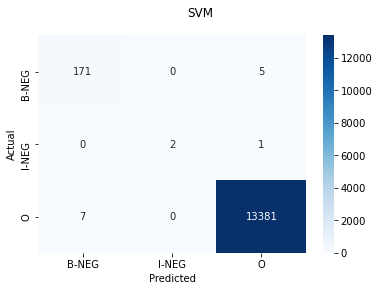

In [38]:
#confusion matrix
confusion_matrix = pd.crosstab(dev['Label'],dev['SVM'],rownames=['Actual'],colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='Blues',fmt='g')
plt.suptitle('SVM')
plt.show()

In [39]:
#save to csv for error analysis
dev.to_csv('SEM_dev_all_features_results.csv',encoding='utf-8-sig',index=False)